In [1]:
!pip install opencv-python

You should consider upgrading via the '/Applications/Робототехника 5 сем/hw/venv/bin/python -m pip install --upgrade pip' command.


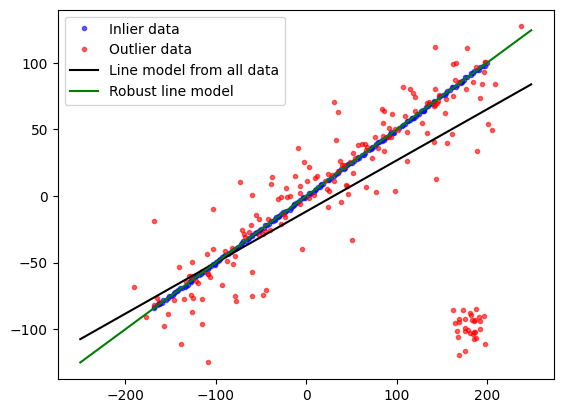

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.measure import LineModelND, ransac
import math
import cv2

rng = np.random.default_rng()

# generate coordinates of line
x = np.arange(-200, 200)
y = 0.5*x 
data = np.column_stack([x, y])

# add gaussian noise to coordinates
noise = rng.normal(size=data.shape)
data += 0.5 * noise
data[::2] += 5 * noise[::2]
data[::4] += 20 * noise[::4]

# add faulty data
faulty = np.array(30 * [(180., -100)])
faulty += 10 * rng.normal(size=faulty.shape)
data[:faulty.shape[0]] = faulty

# fit line using all data
model = LineModelND()
model.estimate(data)

# robustly fit line only using inlier data with RANSAC algorithm
model_robust, inliers = ransac(data, LineModelND, min_samples=2,
                               residual_threshold=1, max_trials=1000)
outliers = inliers == False

# generate coordinates of estimated models
line_x = np.arange(-250, 250)
line_y = model.predict_y(line_x)
line_y_robust = model_robust.predict_y(line_x)

fig, ax = plt.subplots()
ax.plot(data[inliers, 0], data[inliers, 1], '.b', alpha=0.6,
        label='Inlier data')
ax.plot(data[outliers, 0], data[outliers, 1], '.r', alpha=0.6,
        label='Outlier data')
ax.plot(line_x, line_y, '-k', label='Line model from all data')
ax.plot(line_x, line_y_robust, '-g',label='Robust line model')
ax.legend()
plt.show()

In [3]:
def hough_line(img):
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0))
    width, height = img.shape
    diag_len = int(round(math.sqrt(width * width + height * height)))  # max_dist
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    y_idxs, x_idxs = np.nonzero(img)  # (row, col) indexes to edges

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = round(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos


def show_hough_line(data, accumulator, thetas, rhos):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(data, cmap=plt.cm.gray)
    ax[0].set_title('Input image')
    ax[0].axis('image')

    ax[1].imshow(
        accumulator, cmap='jet',
        extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]])
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')
    plt.show()

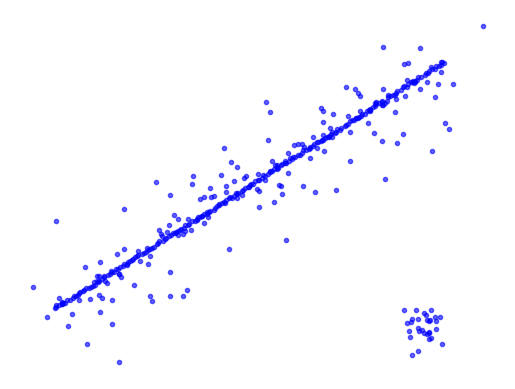

In [4]:
#let's save noisy line from previous hw3
plt.plot(data[inliers, 0], data[inliers, 1], '.b', alpha=0.6,
            label='Inlier data')
plt.plot(data[outliers, 0], data[outliers, 1], '.b', alpha=0.6,
            label='Outlier data')
plt.axis('off')
plt.show()
#plt.savefig('noisyLine.png')

In [5]:
# hw4
# Импортировать картинки, обрабатывать картинки, превращать их в серые
img = cv2.imread('noisyLine.png')
drawing = np.zeros(img.shape[:], dtype=np.uint8)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150)

accumulator, thetas, rhos = hough_line(edges)
show_hough_line(edges, accumulator, thetas, rhos)

[ WARN:0@0.399] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('noisyLine.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
# Easiest peak finding based on max votes
idx = np.argmax(accumulator)
rho = rhos[int(idx / accumulator.shape[1])]
theta = thetas[idx % accumulator.shape[1]]
print("rho={0:.2f}, theta={1:.0f}".format(rho, np.rad2deg(theta)))

In [ ]:
#let's compare initial line and Hough transformed result
yHough = math.cos(theta) * x / math.sin(theta) #+ rho / math.sin(theta) - считывал с фото, а на нем нет системы координат
plt.plot(x, yHough, 'g', label='Hough transform result line')
plt.plot(x, y, 'r', label='initial linear function')

plt.legend()
plt.show()